In [1]:
from sklearn import ensemble, cross_validation, learning_curve, metrics
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import GroupKFold

from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from scipy.stats.kde import gaussian_kde
from scipy.optimize import brentq

import itertools

C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are mov

In [2]:
triplexes = pd.read_csv('basetriples3.csv', header=0, sep='\t')

In [3]:
triplexes.head()

,pdb_chain,type,dssrs,bps,dists,same12,local12,longrange12,same23,local23,...,h3p5,b3p5,i3p5,j3p5,lc3p5,li3p5,lp3p5,fl3p5,fed3p5,istriple
0,1b23.cif1_R,123,R.4SU.8.R.A.13.R.A.14.,-_-_tWH,9.57_5.75_10.04,0,0,1,1,0,...,1,0,0,0,1,0,0,9,2,0
1,1b23.cif1_R,123,R.4SU.8.R.A.13.R.A.46.,-_-_cSS,9.57_12.47_4.86,0,0,1,0,0,...,0,0,0,0,0,0,0,5,1,0
2,1b23.cif1_R,123,R.A.13.R.G.15.R.A.46.,-_-_-,10.88_14.44_12.47,1,0,0,0,0,...,0,0,0,0,0,0,0,5,1,0
3,1b23.cif1_R,110,R.A.14.R.A.46.R.G.52.,t.W_-_-,12.76_21.27_28.07,0,0,1,0,1,...,1,0,0,0,1,0,0,7,3,0
4,1b23.cif1_R,110,R.A.9.R.A.13.R.G.30.,tHW_-_-,11.7_28.0_21.92,0,0,1,0,0,...,1,0,0,0,1,0,0,9,4,0


In [4]:
### !!!!! необходимые данные

triplexes_data = triplexes.iloc[:, 5:475]
triplexes_target = triplexes.iloc[:, 476]

In [5]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap="YlGnBu"):  #"YlGnBu" plt.cm.gray_r
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    print("CONFUSION MATRIX")
    print(df_confusion)
    a = itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1]))
    for i, j in itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1])):
        if i == 2:
            i_ = 'All'
        else:
            i_ = i
        if j == 2:
            j_ = 'All'
        else:
            j_ = j
        plt.text(i, j, df_confusion[i_][j_], horizontalalignment="center", color='black')
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    
    
    
def probability_density(y_prob, y):
    
    kde1 = gaussian_kde(y_prob[y == 1])
    kde2 = gaussian_kde(y_prob[y == 0])
    
    x1 = np.linspace(np.min(y_prob[y == 1]),np.max(y_prob[y == 1]),500)
    x2 = np.linspace(np.min(y_prob[y == 0]),np.max(y_prob[y == 0]),500)
    
    try:
        treshold = brentq(lambda x : kde1(x) - kde2(x), x2[np.argmax(kde1(x1))], x1[np.argmax(kde2(x2))])
    except ValueError:
        treshold = 0.5
        
    plt.fill_between(x1,kde1(x1),0, color='darkblue', alpha = 0.5, label = 'Triplexes')
    plt.fill_between(x2,kde2(x2), 0, color='darkgrey', alpha = 0.5, label = 'Non-triplexes')
    plt.axvline(x1[np.argmax(kde1(x1))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(x2[np.argmax(kde2(x2))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(treshold, color='black', linestyle='-.', alpha = 0.7, label = str(round(treshold,2)))
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title('Probability Distributions')
    plt.xlabel('Probabilities')


In [6]:
#используемая модель
rf_classifier_cv = ensemble.RandomForestClassifier(n_estimators=50, max_depth=10, random_state=1)

TEST_GROUPS Counter({'3j7q.cif1_5': 1316, '3j79.cif1_A': 965, '3j7p.cif1_S2': 765, '6ha1.cif1_a': 644, '6az1.cif1_1': 584, '3jam.cif1_2': 507, '5mrc.cif1_aa': 419, '5t5h.cif1_A': 342, '4p95.cif1_A': 89, '1u9s.cif1_A': 72, '3j79.cif1_B': 63, '3j7o.cif1_7': 58, '4ioa.cif1_Y': 54, '4yaz.cif1_R': 48, '5fjc.cif1_A': 45, '5tbw.cif1_AS': 43, '4oqu.cif1_A': 38, '2r8s.cif1_R': 34, '4uyk.cif1_R': 33, '2der.cif1_D': 32, '3v7e.cif1_C': 32, '3iwn.cif1_A': 31, '4qk9.cif1_A': 29, '5aj0.cif1_Bv': 27, '3dil.cif1_A': 26, '6gaz.cif1_AV': 26, '4v8n.cif1_CV': 25, '5u3g.cif1_B': 25, '3skl.cif1_B': 24, '4qlm.cif1_A': 24, '6gaw.cif1_BB': 24, '1qf6.cif1_B': 23, '3d2v.cif1_A': 23, '3wfs.cif1_A': 22, '5jup.cif1_EC': 21, '1ser.cif1_T': 20, '3rkf.cif1_C': 20, '5oql.cif1_2': 20, '1y26.cif1_X': 19, '4y1m.cif1_B': 19, '5lzs.cif1_3': 19, '1y27.cif1_X': 18, '5b63.cif1_D': 17, '5t5h.cif1_C': 17, '4rge.cif1_C': 16, '4xnr.cif1_X': 16, '5ktj.cif1_A': 14, '4enc.cif1_A': 13, '4wfl.cif1_A': 12, '1et4.cif1_A': 11, '3jcs.cif1_3

Name: 2414, dtype: object

PROBA:  [0.70387509 0.29612491]

equal


equal


equal


equal

type                             111
dssrs    A.G.1299.A.A.1306.A.C.1456.
bps                      tWW_cWS_cWW
dists                12.7_5.59_10.52
Name: 2418, dtype: object

PROBA:  [0.50300283 0.49699717]

equal


equal


equal


equal

type                             111
dssrs    A.U.1336.A.C.3499.A.C.3501.
bps                        tWW_tSH_-
dists                8.94_8.48_15.01
Name: 2422, dtype: object

PROBA:  [0.74494193 0.25505807]

equal


equal


equal


equal


equal


equal


equal

type                             111
dssrs    A.A.1617.A.U.2148.A.A.2645.
bps                        cWS_cWW_-
dists               9.67_10.22_12.31
Name: 2429, dtype: object

PROBA:  [0.62631959 0.37368041]

equal


equal


equal


equal


equal


equal


equal


equal

type                             111
dssrs    A.U.1682.A.A.1730.A.A.2019.
bps                        tWH_tWW_-
dists                9.72



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  3skl.cif1_B
[[20  0]
 [ 0  4]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


e



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  6ha



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                       111
dssrs    R.C.15.R.A.39.R.G.63.
bps                  tSW_-_cWW
dists          9.14_8.86_10.72
Name: 9485, dtype: object

PROBA:  [0.72539733 0.27460267]

equal

type                       111
dssrs    R.U.23.R.U.30.R.A.46.
bps                  -_cWH_cSW
dists          11.73_8.51_9.09
Name: 9486, dtype: object

PROBA:  [0.60020719 0.39979281]

equal

type                       111
dssrs    R.C.25.R.G.52.R.A.53.
bps                  cWW_cSW_-
dists         10.94_7.26_12.15
Name: 9487, dtype: object

PROBA:  [0.57621542 0.42378458]

equal


equal

type                       111
dssrs    R.G.29.R.A.45.R.C.48.
bps                  tS._-_cWW
dists          8.31_5.96_10.75
Name: 9489, dtype: object

PROBA:  [0.53327176 0.46672824]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CON

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  3jam.cif1_2
[[430   4]
 [ 24  49]]


type                         110
dssrs    3.A.32.3.G.182.3.U.193.
bps                      -_-_cHW
dists          17.36_25.77_11.95
Name: 6294, dtype: object

PROBA:  [0.37496439 0.62503561]

equal


equal


equal


equal


equal

type                        111
dssrs    3.A.8.3.C.102.3.G.132.
bps                 cSS_cWW_tWW
dists          5.65_10.64_13.09
Name: 6299, dtype: object

PROBA:  [0.62460076 0.37539924]

equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  3jcs.cif1_3
[[8 1]
 [1 1]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equa

equal


equal


equal


equal


equal

type                             111
dssrs    5.C.1662.5.G.2287.5.G.2320.
bps                      cWW_t.W_cSS
dists               10.71_13.45_5.31
Name: 4934, dtype: object

PROBA:  [0.53974266 0.46025734]

equal


equal


equal


equal


equal


equal


equal


equal


equal

type                             111
dssrs    5.G.1810.5.C.1827.5.C.1828.
bps                        cWW_-_cWW
dists               13.43_5.73_10.59
Name: 4943, dtype: object

PROBA:  [0.79032283 0.20967717]

equal

type                             111
dssrs    5.A.1858.5.C.1859.5.C.1875.
bps                        -_cWW_cWW
dists               5.66_10.42_12.38
Name: 4944, dtype: object

PROBA:  [0.691845 0.308155]

equal

type                             111
dssrs    5.A.1867.5.U.4403.5.G.4440.
bps                      cSS_cWW_tWW
dists               5.25_10.36_12.18
Name: 4945, dtype: object

PROBA:  [0.60164305 0.39835695]

equal

type                             111
dssr

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal






equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                          112
dssrs    BB.G.10.BB.A.24.BB.A.47.
bps                       -_tHW_-
dists             16.31_12.5_11.8
Name: 31886, dtype: object

PROBA:  [0.46436298 0.53563702]

equal

type                         111
dssrs    BB.U.8.BB.U.13.BB.A.23.
bps                  tWW_tHS_tSW
dists             9.67_9.65_9.24
Name: 31887, dtype: object

PROBA:  [0.57364681 0.42635319]

equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  6gaw.cif1_BB
[[19  1]
 [ 1  3]]



equal


equal


equal


equal


equal


equal


equal


equal


equal

type                          110
dssrs    AS.A.27.AS.U.53.AS.A.55.
bps                     cWW_cSH_-
dists            10.31_7.35_11.99
Name: 22946, dtype: object

PROBA:  [0.2956051 0.7043949]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


eq


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                           111
dssrs    S2.G.7.S2.G.16.S2.A.1195.
bps                      cWW_tSH_-
dists               12.59_9.54_9.4
Name: 3785, dtype: object

PROBA:  [0.75429586 0.24570414]

equal


equal

type                              111
dssrs    S2.G.10.S2.U.1201.S2.A.1697.
bps                         cWW_cWW_-
dists                11

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal




equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  6az1.cif1_1
[[499   1]
 [ 32  52]]



equal


equal

type                        111
dssrs    E.A.8.E.C.101.E.G.131.
bps                   cSS_cWW_-
dists          3.52_10.68_12.59
Name: 21240, dtype: object

PROBA:  [0.74405024 0.25594976]

equal


equal

CONFUSION MATRIX By chain:  5t5h.cif1_E
[[3 0]
 [1 0]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  3wfs.cif1_A
[[18  0]
 [ 0  4]]



equal


equal


equal


equal

CONFUSION MATRIX By chain:  6ha8.cif1_x
[[3 0]
 [0 1]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  4xnr.cif1_X
[[13  0]
 [ 0  3]]



equal


equal


equal


equal


equal


equal


equal


equal


equal



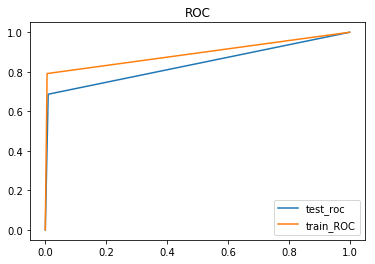


REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      5880
          1       0.93      0.69      0.79      1011

avg / total       0.94      0.95      0.94      6891

ACCURACY =  0.9458714264983311
-----------------
TEST_GROUPS Counter({'4v9f.cif1_0': 1152, '4ioa.cif1_X': 993, '5mrc.cif1_A': 833, '6d9j.cif1_5': 726, '5ool.cif1_A': 571, '3j7a.cif1_A': 489, '5xyi.cif1_2': 428, '6d9j.cif1_2': 381, '1u6b.cif1_B': 76, '5fdv.cif1_1B': 72, '3igi.cif1_A': 63, '4gxy.cif1_A': 55, '5xy3.cif1_3': 53, '3mxh.cif1_R': 46, '4r4v.cif1_A': 44, '6ha1.cif1_B': 42, '4qk8.cif1_A': 37, '3ndb.cif1_M': 33, '6d9j.cif1_7': 33, '4prf.cif1_B': 32, '5e6m.cif1_C': 32, '3u4m.cif1_B': 30, '4mgn.cif1_A': 29, '6eri.cif1_AB': 27, '2qus.cif1_A': 26, '1fir.cif1_A': 25, '2csx.cif1_C': 25, '3kfu.cif1_L': 25, '1u0b.cif1_A': 24, '5mgp.cif1_x': 24, '3ski.cif1_A': 23, '5axm.cif1_P': 23, '2xdb.cif1_G': 22, '4gcw.cif1_B': 21, '5xy3.cif1_4': 21, '3g9c.cif1_Q': 20, '5aox.cif1_C

type                             111
dssrs    0.G.2072.0.A.2490.0.U.2531.
bps                        cSS_cWW_-
dists               4.53_10.68_13.17
Name: 11035, dtype: object

PROBA:  [0.86320892 0.13679108]

equal

type                             111
dssrs    0.C.2087.0.G.2657.0.A.2841.
bps                        cWW_tSW_-
dists               10.67_9.37_11.11
Name: 11036, dtype: object

PROBA:  [0.66559881 0.33440119]

equal

type                             111
dssrs    0.C.2088.0.G.2656.0.A.2840.
bps                        cWW_-_cSW
dists               10.84_12.05_9.68
Name: 11037, dtype: object

PROBA:  [0.64147815 0.35852185]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                             111
dssrs    0.U.2384.0.G.2404.0.U.2419.
bps                        cWW_tHW_-
dists               10.58_10.08_12.9
Name: 11053, dtype: object

PROBA:  [0.54150906 0.45849094]

equal


equal


equal





equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                             100
dssrs    B.G.2127.B.C.2129.B.G.2168.
bps                            -_-_-
dists              11.12_28.21_23.98
Name: 6705, dtype: object

PROBA:  [0.36214415 0.63785585]

equal


equal

type                             112
dssrs    B.G.2166.B.A.2171.B.U.2172.
bps                          -_-_tWH
dists               10.99_4.43_12.58
Name: 6707, dtype: object

PROBA:  [0.42824917 0.57175083]

equal


equal


equal


equal

type                             111
dssrs    B.C.2111.B.U.2144.B.G.2147.
bps                        -_tSW_cWH
dists                 9.91_9.42_8.55
Name: 6711, dtype: object

PROBA:  [0.77030755 0.22969245]

equal

type                             111
dssrs    B.A.2114.B.A.2119.B.G.2168.
bps                        tWH_tWS_-
dists                12.08_9.93_6.11
Name: 6712, dtype: object

PROBA:  [0.69182564 0.30817436]

equal

type               

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  3j7a.cif1_A
[[417   2]
 [ 19  51]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  1mms.cif1_C
[[10  0]
 [ 0  3]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                        111
dssrs    A.U.71.A.G.79.A.A.113.
bps                   cWW_tSS_-
dists           10.26_8.22_7.26
Name: 9256, dtype: object

PROBA:  [0.6286684 0.3713316]

equal


equal


equal


equal


equal


equal


e



equal


equal


equal

type                             111
dssrs    A.A.1318.A.U.1600.A.A.1909.
bps                        cWS_cWW_-
dists               9.29_10.56_11.14
Name: 17310, dtype: object

PROBA:  [0.70778382 0.29221618]

equal


equal

type                             111
dssrs    A.C.1364.A.G.1401.A.A.1535.
bps                        cWW_tSW_-
dists                10.73_9.77_9.44
Name: 17312, dtype: object

PROBA:  [0.64219721 0.35780279]

equal


equal


equal


equal


equal

type                             111
dssrs    A.U.1645.A.A.1737.A.U.1876.
bps                      cWW_c.W_cHW
dists               10.07_13.52_9.38
Name: 17317, dtype: object

PROBA:  [0.60048319 0.39951681]

equal

type                             111
dssrs    A.G.1665.A.A.2961.A.U.3051.
bps                        tHS_cWW_-
dists                6.68_10.65_5.61
Name: 17318, dtype: object

PROBA:  [0.73782857 0.26217143]

equal

type                             111
dssrs    A.C.1700.A.G.1734.A.A.180


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                             111
dssrs    A.A.1718.A.C.1911.A.G.2008.
bps                        cSS_cWW_-
dists                5.7_10.53_12.44
Name: 20521, dtype: object

PROBA:  [0.75672466 0.24327534]

equal

type                             111
dssrs    A.G.1719.A.C.1910.A.G.2009.
bps                        -_cWW_tSS
dists                6.16_10.68_7.77
Name: 20522, dtype: object

PROBA:  [0.73568609 0.26431391]

equal


equal


equal

type                    



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal




equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal




equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  2xdb.cif1_G
[[18  0]
 [ 0  4]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  3kfu.cif1_L
[[21  0]
 [ 0  4]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  6d9j.cif1_7
[[28  0]
 [ 0  5]]



equal


equal

CONFUSION MATRIX By chain:  5h9f.cif1_L
[[2]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type            


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  6d9j.cif1_5
[[619   3]
 [ 31  73]]



equal


equal


equal


equal

type                       110
dssrs    4.G.57.4.U.58.4.A.62.
bps                      -_-_-
dists          5.19_6.05_10.51
Name: 25286, dtype: object

PROBA:  [0.45341704 0.54658296]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                       111
dssrs    4.A.72.4.A.82.4.G.87.
bps                  tWS_-_tHS
dists           8.72_7.74_9.25
Name: 25296, dtype: object

PROBA:  [0.50995696 0.49004304]

equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  5xy3.cif1_4
[[17  1]
 [ 1  2]]



equal

type                         123
dssrs    AV.U.8.AV.C.13.AV.A.23.
bps     



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  2csx.cif1_C
[[21  0]
 [ 0  4]]



equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  4pqv.cif1_A
[[5]]



equal


equal


equal

type                       112
dssrs    C.C.13.C.A.22.C.G.47.
bps                      -_-_-
dists         8.09_13.86_14.71
Name: 1261, dtype: object

PROBA:  [0.42710836 0.57289164]

equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  2zni.cif1_C
[[8 1]
 [0 2]]



equal


equal


equal

CONFUSION MATRIX By chain:  5voe.cif1_A
[[2 0]
 [0 1]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                          110
dssrs    A.C.127.A.U.198.A.G.239.
bps                       -_-_cWW
dists            27.6_25.54_10.68
Name: 1591, dtype: object

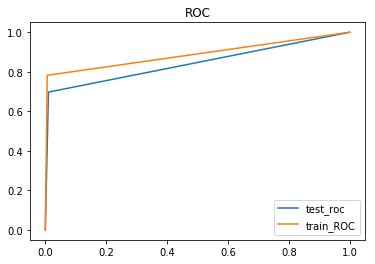


REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      5877
          1       0.92      0.70      0.79      1014

avg / total       0.95      0.95      0.94      6891

ACCURACY =  0.9465970105935277
-----------------
TEST_GROUPS Counter({'4y4o.cif1_2A': 1113, '6eri.cif1_AA': 1012, '5tbw.cif1_1': 936, '4v88.cif1_A6': 637, '5o5j.cif1_A': 574, '6gaw.cif1_BA': 539, '6az3.cif1_1': 397, '3j9m.cif1_AA': 320, '5oql.cif1_1': 156, '1nbs.cif1_B': 65, '2a64.cif1_A': 62, '5j7l.cif1_DB': 55, '6ek0.cif1_L7': 50, '6az3.cif1_8': 46, '4kqy.cif1_A': 43, '6d90.cif1_4': 40, '5lys.cif1_B': 34, '5t83.cif1_A': 33, '5wt1.cif1_C': 33, '4yye.cif1_C': 32, '1h4s.cif1_T': 31, '4lck.cif1_F': 30, '5tbw.cif1_4': 27, '2du3.cif1_D': 26, '4p5j.cif1_A': 26, '6az3.cif1_5': 25, '6ck5.cif1_A': 25, '2gdi.cif1_X': 24, '4qei.cif1_C': 24, '5o2r.cif1_x': 24, '2azx.cif1_D': 23, '5d8h.cif1_A': 23, '5ns3.cif1_C': 22, '6ek0.cif1_L8': 21, '1n78.cif1_C': 20, '3w3s.cif1_B': 20, '4lx

type                               111
dssrs    BA.G.339.BA.G.1067.BA.U.1260.
bps                          cSS_cWW_-
dists                  4.6_10.26_13.56
Name: 32228, dtype: object

PROBA:  [0.66385407 0.33614593]

equal


equal


equal

type                               111
dssrs    BA.A.376.BA.U.1061.BA.A.1267.
bps                          cHS_cWW_-
dists                 8.05_10.39_12.34
Name: 32231, dtype: object

PROBA:  [0.62174024 0.37825976]

equal

type                              111
dssrs    BA.G.442.BA.C.449.BA.G.1150.
bps                         cWW_-_tSW
dists                10.41_8.93_11.24
Name: 32232, dtype: object

PROBA:  [0.61826012 0.38173988]

equal


equal


equal


equal


equal


equal

type                               111
dssrs    BA.A.562.BA.U.1286.BA.A.1310.
bps                          tHS_cWW_-
dists                 9.21_10.64_10.66
Name: 32238, dtype: object

PROBA:  [0.6722472 0.3277528]

equal

type                               111
dssrs    BA.U.5


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  6az3.cif1_1
[[340   0]
 [ 16  41]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                       110
dssrs    B.U.40.B.A.43.B.G.64.
bps                    cWH_-_-
dists           8.



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal




equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  4v88.cif1_A6
[[543   2]
 [ 26  66]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  6ek0.cif1_L8
[[18  0]
 [ 0  3]]



equal


equal


equal


equal


equal


equal


equal


equal


equal

type                       100
dssrs    x.G.45.x.G.68.x.C.71.
bps                      -_-_-
dists        26.09_15.44_39.15
Name: 18561, dtype: object

PROBA:  [0.43079313 0.56920687]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRI


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal




equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal



type                         111
dssrs    A.A.55.A.U.110.A.A.313.
bps                    cHS_cWW_-
dists            7.65_10.64_12.5
Name: 18913, dtype: object

PROBA:  [0.6044958 0.3955042]

equal


equal

type                         111
dssrs    A.A.69.A.C.213.A.G.218.
bps                    -_cWW_tWS
dists            6.54_10.61_8.77
Name: 18915, dtype: object

PROBA:  [0.63868877 0.36131123]

equal


equal


equal


equal

type                          111
dssrs    A.G.108.A.A.315.A.U.328.
bps                     cWW_cHH_-
dists            12.77_7.94_16.02
Name: 18919, dtype: object

PROBA:  [0.85031137 0.14968863]

equal


equal


equal


equal


equal

type                          111
dssrs    A.U.125.A.G.232.A.G.262.
bps                     cWW_tSW_-
dists            10.68_8.45_13.32
Name: 18924, dtype: object

PROBA:  [0.70545116 0.29454884]

equal

type                          111
dssrs    A.G.126.A.C.191.A.G.196.
bps                     -_cWW_cHS
dists             11.29_10.5

equal


equal


equal


equal

type                             111
dssrs    AA.G.874.AA.A.881.AA.C.915.
bps                        -_cSS_cWW
dists               13.23_5.81_10.41
Name: 5645, dtype: object

PROBA:  [0.53264297 0.46735703]

equal


equal


equal


equal


equal


equal


equal


equal

type                               111
dssrs    AA.A.977.AA.A.1010.AA.C.1065.
bps                          tWH_tWS_-
dists                  12.06_7.9_10.65
Name: 5653, dtype: object

PROBA:  [0.78734312 0.21265688]

equal


equal

type                                111
dssrs    AA.U.1055.AA.G.1576.AA.C.1589.
bps                           tWS_cWW_-
dists                    7.8_10.75_6.31
Name: 5655, dtype: object

PROBA:  [0.58726549 0.41273451]

equal


equal


equal


equal


equal


equal


equal


equal


equal

type                                111
dssrs    AA.A.1232.AA.G.1401.AA.A.1444.
bps                           tWS_-_tHW
dists                  10.21_6.39_12.33
Name: 5664, dtyp



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  5lzs.cif1_2
[[8 0]
 [0 2]]



equal


equal


equal


equal

CONFUSION MATRIX By chain:  5xtm.cif1_D
[[3 0]
 [0 1]]



equal


equal


equal


equal


equal

type                       110
dssrs    C.G.12.C.U.25.C.G.45.
bps                    -_cWW_-
dists          7.72_12.7_14.33
Name: 9213, dtype: object

PROBA:  [0.4947324 0.5052676]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                       111
dssrs    C.U.13.C.U.22.C.A.46.
bps                  cWW_tHW_-
dists         8.86_12.24_11.75
Name: 9224, dtype: object

PROBA:  [0.74705092 0.25294908]

equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  4qei.cif1_C
[[19  1]
 [ 1  3]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equ

type                                111
dssrs    2A.U.1352.2A.A.1378.2A.A.1569.
bps                           tWH_tWW_-
dists                   9.76_13.39_9.89
Name: 13298, dtype: object

PROBA:  [0.71047612 0.28952388]

equal


equal


equal


equal


equal


equal


equal


equal

type                                111
dssrs    2A.C.1631.2A.G.1635.2A.A.1760.
bps                           cWW_-_tSW
dists                  10.65_11.02_9.11
Name: 13306, dtype: object

PROBA:  [0.79585545 0.20414455]

equal


equal

type                                111
dssrs    2A.C.1660.2A.G.2000.2A.U.2689.
bps                           cWW_cSW_-
dists                    10.53_7.8_11.2
Name: 13308, dtype: object

PROBA:  [0.583753 0.416247]

equal


equal


equal


equal


equal


equal

type                                111
dssrs    2A.U.1709.2A.A.1749.2A.G.2859.
bps                           cWW_-_cSS
dists                    10.4_12.4_5.48
Name: 13314, dtype: object

PROBA:  [0.64013232 0.359867

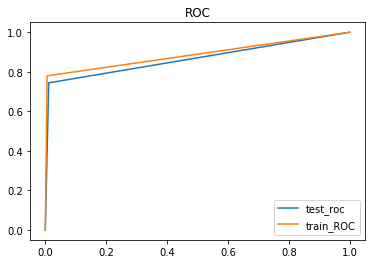


REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      5871
          1       0.92      0.74      0.82      1020

avg / total       0.95      0.95      0.95      6891

ACCURACY =  0.9525468001741402
-----------------
TEST_GROUPS Counter({'5j7l.cif1_DA': 1101, '6ha1.cif1_A': 1026, '5xxb.cif1_1': 845, '5xy3.cif1_1': 762, '6ek0.cif1_S2': 546, '5xxu.cif1_2': 473, '5ngm.cif1_Aa': 462, '5t5h.cif1_B': 287, '6gaz.cif1_AA': 275, '4wf9.cif1_Y': 57, '5t5h.cif1_D': 53, '3ivk.cif1_M': 48, '5xym.cif1_B': 45, '4plx.cif1_A': 42, '4ycp.cif1_B': 38, '1c0a.cif1_B': 34, '4y1j.cif1_A': 33, '4rdx.cif1_C': 32, '3f2x.cif1_X': 31, '4wj4.cif1_B': 31, '1j1u.cif1_B': 28, '5ccb.cif1_N': 27, '3j79.cif1_C': 26, '5hr7.cif1_D': 26, '1evv.cif1_A': 25, '2d6f.cif1_F': 24, '6cb3.cif1_B': 24, '6d9j.cif1_8': 24, '1gax.cif1_D': 23, '3al0.cif1_E': 23, '5ool.cif1_B': 23, '1hc8.cif1_C': 21, '6az3.cif1_7': 21, '4jrc.cif1_B': 20, '6az3.cif1_3': 20, '3d0u.cif1_A': 19, '3ivn.ci

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                                112
dssrs    DA.G.2644.DA.C.2646.DA.G.2674.
bps                             -_cWW_-
dists                 11.72_10.71_19.34
Name: 15341, dtype: object

PROBA:  [0.32551745 0.67448255]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                                112
dssrs

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal






equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  5ccb.cif1_N
[[22  0]
 [ 0  5]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                       112
dssrs    B.A.14.B.G.19.B.A.21.
bps                    -_-_cWS
dists         18.83_12.37_9.47
Name: 13773, dtype: object

PROBA:  [0.47445456 0.52554544]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                       111
dssrs    B.G.19.B.U.20.B.C.56.
bps                  cSH_-_cWW
dists         6.26_12.29_10.57
Name: 13784, dtype: object

PROBA:  [0.64279354 0.35720646]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  4ycp.cif1_B
[[31  1]
 



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                       111
dssrs    1.A.37.1.U.42.1.G.92.
bps                  -_tWW_cSW
dists          11.66_11.58_7.8
Name: 24956, dtype: object

PROBA:  [0.60186247 0.39813753]

equal


equal


equal

type                         111
dssrs    1.A.69.1.G.276.1.C.285.
bps                    tWS_cWW_-
dists           9.79_11.09_10.87
Name: 24959, dtype: object

PROBA:  [0.57750769 0.42249231]

equal


equal


equal


equal


equal

type                            111
dssrs    1.A.257.1.C.2231.1.G.2240.
bps                       -_cWW_cWS
dists               13.23_10.85_9.9
Name: 24964, dtype: object

PROBA:  [0.73687694 0.26312

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  5xy3.cif1_1
[[652   1]
 [ 40  69]]



equal


equal


equal


equal


equal


equal


equal

type                        100
dssrs    3.A.67.3.U.68.3.C.188.
bps                       -_-_-
dists          5.94_33.01_35.65
Name: 26878, dty

type                       111
dssrs    X.G.32.X.G.62.X.C.83.
bps                t.W_cSS_cWW
dists         13.23_5.39_10.97
Name: 1503, dtype: object

PROBA:  [0.63410588 0.36589412]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  3f2x.cif1_X
[[26  0]
 [ 2  3]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                       110
dssrs    D.A.32.D.C.39.D.U.45.
bps                    -_-_cWW
dists         18.65_17.96_9.84
Name: 21256, dtype: object

PROBA:  [0.30202923 0.69797077]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                       112
dssrs    D.A.27.D.U.52.D.A.54.
bps                  cWW_cSH_-
dists         10.59_7.83_11.95
Name: 21270, dtype: object

PROBA:  [0.28408981 0.71591019]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equ



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  5xxb.cif1_1
[[724   0]
 [ 32  89]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                            111
dssrs    S2.C.35.S2.A.520.S2.A.825.
bps                       cWW_cSW_-
dists               10.39_5.88_13.0
Name: 29951, dtype: object

PROBA:  [0.75084883 0.24915117]

equal


equal

type                           111
dssrs    S2.A.46.S2.U.97.S2.A.433.
bps                      cHS_cWW_-
dists              7.77_10.44_12.0
Name: 29953, dtype: object

PROBA:  [0.55603293 0.44396707]

equal


equal

type                            111
dssrs    S2.A.60.S2.G.316.S2.C.334.
bps                       cWS_cWW_-
dists              6.23_11.58_13.63
Name: 29955, dtype: object

PROBA:  [0.75457121 0.24542879]

equal

type                            111
dssrs    S2.A.61.S2.C.315.S2.G.335.
bps                       -_cWW_tSS
dists               5.73_10.73_8.59
Name: 29956, dtype: object

PROBA:  [0.75715147 0.24284853]

equal


equal


equal

type         



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                            112
dssrs    A.A.689.A.G.1362.A.C.1370.
bps                         -_cWW_-
dists            114.22_11.1_123.83
Name: 33878, dtype: object

PROBA:  [0.46284372 0.53715628]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


eq

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  6ha1.cif1_A
[[876   3]
 [ 41 106]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                        111
dssrs    A.A.20.A.G.66.A.A.124.
bps                   cWW_tSW_-
dists         12.71_10.09_13.39
Name: 1373, dtype: object

PROBA:  [0.58307819 0.41692181]

equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  3d0u.cif1_A
[[16  0]
 [ 1  2]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal



equal

type                            111
dssrs    2.U.313.2.A.1111.2.G.1125.
bps                       cWW_tHS_-
dists               12.39_9.83_7.83
Name: 24334, dtype: object

PROBA:  [0.84678974 0.15321026]

equal


equal


equal


equal

type                          111
dssrs    2.G.364.2.G.377.2.A.753.
bps                     tHS_-_tSW
dists            10.58_19.07_9.72
Name: 24338, dtype: object

PROBA:  [0.65848441 0.34151559]

equal

type                          111
dssrs    2.C.442.2.G.462.2.A.524.
bps                     cWW_-_cSW
dists             11.04_10.87_9.7
Name: 24339, dtype: object

PROBA:  [0.57740822 0.42259178]

equal

type                          111
dssrs    2.C.444.2.A.446.2.G.461.
bps                     cWH_tWS_-
dists              9.09_9.56_9.04
Name: 24340, dtype: object

PROBA:  [0.65931043 0.34068957]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                            111
dssrs    2.A.974.2.C.1764.2.G

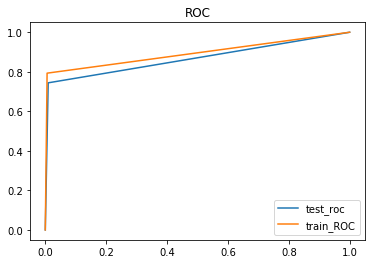


REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      5875
          1       0.93      0.74      0.83      1016

avg / total       0.95      0.95      0.95      6891

ACCURACY =  0.9541430851835728
-----------------
TEST_GROUPS Counter({'6ek0.cif1_L5': 1043, '5o60.cif1_A': 1038, '4wf9.cif1_X': 943, '5j7l.cif1_AA': 652, '4lfb.cif1_A': 588, '6eri.cif1_BA': 543, '5an9.cif1_N': 413, '6az3.cif1_2': 284, '5t2a.cif1_B': 250, '4v9f.cif1_9': 59, '3pdr.cif1_X': 54, '5xxb.cif1_3': 49, '5ml7.cif1_B': 46, '6eri.cif1_Ax': 43, '2qwy.cif1_C': 39, '1yfg.cif1_A': 35, '4aob.cif1_A': 33, '1mfq.cif1_A': 32, '4pr6.cif1_B': 32, '3hhn.cif1_E': 31, '3wqy.cif1_C': 30, '4yco.cif1_D': 27, '3amu.cif1_B': 26, '6az3.cif1_4': 26, '3q3z.cif1_V': 25, '4mgn.cif1_B': 25, '1il2.cif1_C': 24, '1qtq.cif1_B': 24, '5mrc.cif1_bb': 24, '5hr6.cif1_C': 23, '5l4o.cif1_A': 23, '3eph.cif1_E': 22, '6cfj.cif1_1x': 21, '2xd0.cif1_W': 20, '5mmm.cif1_z': 20, '5zwn.cif1_P': 20, '1b23.


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  6ek0.cif1_L5
[[889   5]
 [ 44



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  5j7l.cif1_AA
[[557   2]
 [ 21  72]]



equal

CONFUSION MATRIX By chain:  1q96.cif1_A
[[1]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                             110
dssrs    2.G.1255.2.A.1259.2.U.1265.
bps                          cWH_-_-
dists              13.17_21.38_21.96
Name: 26945, dtype: object

PROBA:  [0.26856483 0.73143517]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equa

[[14  2]
 [ 0  4]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


eq

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  4wf9.cif1_X
[[806   2]
 [ 34 101]]



equal


equal


equal


equal


equal

type                          123
dssrs    Ax.C.27.Ax.A.29.Ax.G.54.
bps                         -_-_-
dists           10.49_13.63_17.77
Name: 30252, dtype: object

PROBA:  [0.38788483 0.61211517]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                          112
dssrs    Ax.C.28.Ax.A.57.Ax.A.58.
bps                         -_-_-
dists            15.93_5.44_13.71
Name


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                            111
dssrs    A.G.137.A.G.1524.A.C.1811.
bps                       cWS_cWW_-
dists              6.51_10.61_13.04
Name: 19752, dtype: object

PROBA:  [0.70214437 0.29785563]

equal


equal


equal


equal


equal

type                          111
dssrs    A.U.199.A.G.250.A.G.474.
bps                     tWW_-_cWW
dists            10.94_12.87_7.98
Name: 19757, dtype: object

PROBA:  [0.68372081 0.31627919]

equal


equal

type                          111
dssrs    A.A.222.A.C.495.A.G.508.
bps                     -_cWW_cSS
dists             8.55_10.76_5.81
Name: 19759, dtype: object

PROBA:  [0.572307 0.427693]

equal

type                          111
dssrs    A.A.226.A.G.498.A.C.5


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal





equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                        111
dssrs    X.G.22.X.A.71.X.C.163.
bps                   tSS_-_cWW
dists           7.83_5.61_10.72
Name: 6530, dtype: object

PROBA:  [0.72069419 0.27930581]

equal

type                        111
dssrs    X.C.33.X.A.88.X.G.151.
bps                   -_tSS_cWW
dists           5.95_7.94_10.45
Name: 6531, dtype: object

PROBA:  [0.70092871 0.29907129]

equal


equal


equal


equal

type                        111
dssrs    X.C.69.X.A.72.X.A.105.
bps                   tSH_tWW_-
dists           9.41_13.76_6.27
Name: 6535, dtype: object

PROBA:  [0.80250315 0.19749685]

equal

type                         111
dssrs    X.C.99.X.G.107.X.A.155.
bps                    cWW_tS._-
dists             10.61_8.26_5.8
Name: 6536, dtype:

type                             111
dssrs    A.U.1070.A.G.1094.A.A.1105.
bps                        tHW_-_cWW
dists               11.88_14.0_10.62
Name: 8607, dtype: object

PROBA:  [0.54222759 0.45777241]

equal


equal


equal


equal


equal

type                             111
dssrs    A.G.1124.A.C.1149.A.A.1280.
bps                        cWW_cSW_-
dists               11.12_9.33_12.37
Name: 8612, dtype: object

PROBA:  [0.81054909 0.18945091]

equal


equal


equal

type                             111
dssrs    A.C.1129.A.U.1135.A.G.1138.
bps                        t.W_t.W_-
dists               12.82_9.81_14.27
Name: 8615, dtype: object

PROBA:  [0.69622011 0.30377989]

equal


equal


equal

type                             111
dssrs    A.A.1250.A.G.1353.A.C.1369.
bps                        tWS_cWW_-
dists               10.14_10.63_9.54
Name: 8618, dtype: object

PROBA:  [0.55918662 0.44081338]

equal

type                             111
dssrs    A.G.1255.A.G.1258.A.C.1277.
bp

Name: 14146, dtype: object

PROBA:  [0.72690071 0.27309929]

equal

type                             111
dssrs    N.A.2547.N.A.3291.N.U.3307.
bps                        -_cWW_cSS
dists               10.83_10.33_4.37
Name: 14147, dtype: object

PROBA:  [0.57666547 0.42333453]

equal


equal


equal


equal


equal

type                             111
dssrs    N.A.2639.N.G.3157.N.U.3198.
bps                        cSS_cWW_-
dists               4.19_10.71_13.19
Name: 14152, dtype: object

PROBA:  [0.71504961 0.28495039]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                             111
dssrs    N.U.3052.N.G.3070.N.G.3085.
bps                      cWW_tHH_t.W
dists              10.75_11.66_13.16
Name: 14165, dtype: object

PROBA:  [0.5366529 0.4633471]

equal

type                             111
dssrs    N.U.3155.N.U.3201.N.A.3274.
bps                        cWW_-_cSS
dists               10.54_13.39_5.12
Name: 1416


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  2qwy.cif1_C
[[32  1]
 [ 4  2]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                       112
dssrs    B.G.22.B.C.25.B.G.46.
bps                    -_-_tHW
dists        15.41_15.95_11.42
Name: 1344, dtype: object

PROBA:  [0.48814871 0.51185129]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  3amu.cif1_B
[[21  1]
 [ 0  4]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  5mmm.cif1_z
[[17  0]
 [ 0  3]]

AUC_TRAIN =  0.8862160324212883

AUC =  0.8715350494607866


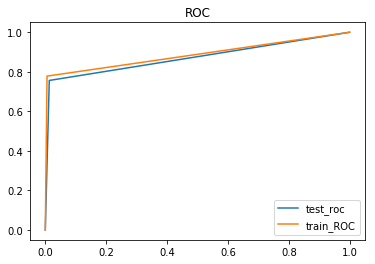


REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      5878
          1       0.91      0.76      0.83      1013

avg / total       0.95      0.95      0.95      6891

ACCURACY =  0.9529821506312581
-----------------


In [7]:
groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=5)
#group_kfold.get_n_splits(X, y, groups)

description = ['type', 'dssrs', 'bps', 'dists']

for train_index, test_index in group_kfold.split(triplexes, triplexes_target, groups):
    #triplexes_data = triplexes.iloc[:, 5:475]
    #print(triplexes_data)
    X_train_middle, X_test_middle = triplexes.loc[list(train_index)], triplexes.loc[test_index]
    X_train = X_train_middle.iloc[:, 5:475]
    X_test = X_test_middle.iloc[:, 5:475]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]

    
    a = Counter(list(triplexes.loc[list(train_index)].pdb_chain.values))
    b = Counter(list(triplexes.loc[list(test_index)].pdb_chain.values))
    
    for key in a:
        if key in b.keys():
            print("FUUUUUUUUU")
    print("TEST_GROUPS", Counter(list(triplexes.pdb_chain.loc[test_index])))
    rf_classifier_cv.fit(X_train, y_train)
    
    #prediction by chains
    chains = list(set(X_test_middle.pdb_chain.values))

    print("")
    for chain in chains:
        middle_check_test = X_test_middle.loc[X_test_middle['pdb_chain'] == chain]
        middle_target_test = middle_check_test['istriple']
        middle_check_test_ = middle_check_test.iloc[:, 5:475]
    
        prediction_result_by_chain = rf_classifier_cv.predict(middle_check_test_)
        predict_proba_by_chain = rf_classifier_cv.predict_proba(middle_check_test_)
        print("")

        
        #PREDICTED PROBABILITIES
        i = 0
        for index, row in middle_check_test.iterrows():
            if middle_target_test[index] != prediction_result_by_chain[i]:
                print(row[description])
                print("")
                print("PROBA: ", predict_proba_by_chain[i])
            i = i + 1
            print("")
            print("equal")
            print("")

        print("CONFUSION MATRIX By chain: ", chain)
        print(confusion_matrix(middle_target_test, prediction_result_by_chain))
        print("")
    
    #simple prediction
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_train)
    auc_train = metrics.roc_auc_score(y_train, prediction_train)
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_result)
    auc = metrics.roc_auc_score(y_test, prediction_result)
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()


    print("")
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY = ", accuracy_score(y_test, prediction_result))
    print("-----------------")


[[5801   77]
 [ 247  766]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          5801   77  5878
1           247  766  1013
All        6048  843  6891


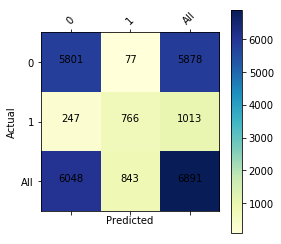

In [8]:
print(confusion_matrix(y_test, prediction_result))
plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))

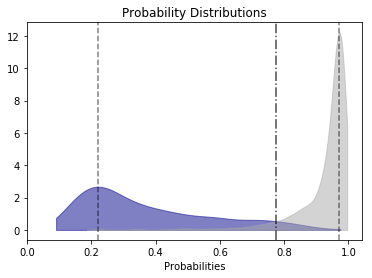

In [9]:
probability_density(prediction_prob[:, 0], y_test)

In [10]:
# 10 фолдов

groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=10)
#group_kfold.get_n_splits(X, y, groups)

for train_index, test_index in group_kfold.split(triplexes_data, triplexes_target, groups):
    print("")
    X_train, X_test = triplexes_data.loc[list(train_index)], triplexes_data.loc[test_index]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]
    rf_classifier_cv.fit(X_train, y_train)
    prediction_result = rf_classifier_cv.predict(X_test)
    print("CONFUSION MATRIX")
    print(confusion_matrix(y_test, prediction_result))
    print("")
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY", accuracy_score(y_test, prediction_result))
    print("-----------------")



CONFUSION MATRIX
[[2902   36]
 [ 154  354]]

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2938
          1       0.91      0.70      0.79       508

avg / total       0.94      0.94      0.94      3446

ACCURACY 0.9448636099825886
-----------------

CONFUSION MATRIX
[[2904   34]
 [ 139  369]]

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2938
          1       0.92      0.73      0.81       508

avg / total       0.95      0.95      0.95      3446

ACCURACY 0.9497968659315148
-----------------

CONFUSION MATRIX
[[2904   34]
 [ 146  362]]

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2938
          1       0.91      0.71      0.80       508

avg / total       0.95      0.95      0.95      3446

ACCURACY 0.9477655252466628
-----------------

CONFUSION MATRIX
[[2913   27]
 [ 130  376]]

REPORT
     

In [11]:
# 15 фолдов

groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=15)

for train_index, test_index in group_kfold.split(triplexes_data, triplexes_target, groups):
    print("TRAIN:", train_index, "TEST:", test_index)
    print("")
    X_train, X_test = triplexes_data.loc[list(train_index)], triplexes_data.loc[test_index]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]
    rf_classifier_cv.fit(X_train, y_train)
    prediction_result = rf_classifier_cv.predict(X_test)
    print("CONFUSION MATRIX")
    print(confusion_matrix(y_test, prediction_result))
    print("")
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY", accuracy_score(y_test, prediction_result))
    print("-----------------")


TRAIN: [   19    20    21 ... 34452 34453 34454] TEST: [    0     1     2 ... 27317 27318 27319]

CONFUSION MATRIX
[[1926   31]
 [ 110  231]]

REPORT
             precision    recall  f1-score   support

          0       0.95      0.98      0.96      1957
          1       0.88      0.68      0.77       341

avg / total       0.94      0.94      0.94      2298

ACCURACY 0.9386422976501305
-----------------
TRAIN: [    0     1     2 ... 34452 34453 34454] TEST: [  313   314   315 ... 29629 29630 29631]

CONFUSION MATRIX
[[1940   22]
 [  97  238]]

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1962
          1       0.92      0.71      0.80       335

avg / total       0.95      0.95      0.95      2297

ACCURACY 0.9481932956029604
-----------------
TRAIN: [    0     1     2 ... 34452 34453 34454] TEST: [   92    93    94 ... 33422 33423 33424]

CONFUSION MATRIX
[[1931   29]
 [  95  242]]

REPORT
             precision    re